In [1]:
import warnings

import matplotlib as mpl
from IPython import get_ipython

import pymor.tools.random

ip = get_ipython()
if ip is not None:
    ip.run_line_magic('matplotlib', 'inline')

warnings.filterwarnings('ignore', category=UserWarning, module='torch')

pymor.tools.random._default_random_state = None

mpl.rcParams['figure.facecolor'] = (1.0, 1.0, 1.0, 0.0)


Loading pyMOR defaults from file /builds/pymor/pymor/docs/source/pymor_defaults.py


(getting-started)=

# Getting Started

pyMOR includes a variety of model order reduction methods
for different types of models.
We illustrate how to use pyMOR on two basic examples and
give pointers to further documentation.

## Installation

pyMOR can be installed via `pip`. To follow this guide, pyMOR should be installed with GUI support:

```bash
pip install pymor[gui]
```

If you follow along in a [Jupyter](https://jupyter.org) notebook, you should install pyMOR using
the `jupyter` extra:

```bash
pip install pymor[jupyter]
```

We also provide [conda-forge](https://conda-forge.org) packages.
For further details see [README.md](https://github.com/pymor/pymor/blob/main/README.md).

## Reduced Basis Method for Elliptic Problem

Here we show how to reduce a parametric linear elliptic problem using the Reduced Basis (RB) method.
As an example we use a standard 2x2 thermal-block problem,
which is given by the elliptic equation

$$
-\nabla \cdot [d(x, \mu) \nabla u(x, \mu)] = 1
$$

on the domain $[0, 1]^2$ with Dirichlet zero boundary values.
The domain is partitioned into 2x2 blocks and
the diffusion function $d(x, \mu)$ is constant
on each such block $i$ with value $\mu_i$.

```
(0,1)---------(1,1)
|        |        |
|  μ_2   |  μ_3   |
|        |        |
|------------------
|        |        |
|  μ_0   |  μ_1   |
|        |        |
(0,0)---------(1,0)
```

After discretization, the model has the form

$$
(L + \mu_0 L_0 + \mu_1 L_1 + \mu_2 L_2 + \mu_3 L_3) u(\mu) = f
$$

We can obtain this discrete full-order model in pyMOR using the
`thermal_block_example` function
from the {mod}`pymor.models.examples` module:

In [2]:
from pymor.models.examples import thermal_block_example

fom_tb = thermal_block_example()

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

This uses pyMOR's `builtin discretization toolkit`
to construct the model.
In the {doc}`builtin-discretizer tutorial <tutorial_builtin_discretizer>` you learn how
to define your own models using this toolkit.

`fom_tb` is an instance of `StationaryModel`, which encodes the mathematical structure
of the model through its `Operators`:

In [3]:
fom_tb

StationaryModel(
    LincombOperator(
        (NumpyMatrixOperator(<20201x20201 sparse, 400 nnz>, source_id='STATE', range_id='STATE', name='boundary_part'),
         NumpyMatrixOperator(<20201x20201 sparse, 24801 nnz>, source_id='STATE', range_id='STATE', name='diffusion_0'),
         NumpyMatrixOperator(<20201x20201 sparse, 24801 nnz>, source_id='STATE', range_id='STATE', name='diffusion_1'),
         NumpyMatrixOperator(<20201x20201 sparse, 24801 nnz>, source_id='STATE', range_id='STATE', name='diffusion_2'),
         NumpyMatrixOperator(<20201x20201 sparse, 24801 nnz>, source_id='STATE', range_id='STATE', name='diffusion_3')),
        (1.0,
         ProjectionParameterFunctional('diffusion', size=4, index=0, name='diffusion_0_0'),
         ProjectionParameterFunctional('diffusion', size=4, index=1, name='diffusion_1_0'),
         ProjectionParameterFunctional('diffusion', size=4, index=2, name='diffusion_0_1'),
         ProjectionParameterFunctional('diffusion', size=4, index=3, na

Its parameters can also be accessed:

In [4]:
fom_tb.parameters

Parameters({diffusion: 4})

Let us show the solution for particular parameter values:

In [5]:
mu = [0.1, 0.2, 0.5, 1]
U = fom_tb.solve(mu)
fom_tb.visualize(U)

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

To construct a reduced-order model using the reduced basis method,
we first need to create a `reductor` which projects
the model onto a given reduced space:

In [6]:
from pymor.parameters.functionals import ExpressionParameterFunctional
from pymor.reductors.coercive import CoerciveRBReductor

reductor = CoerciveRBReductor(
    fom_tb,
    product=fom_tb.h1_0_semi_product,
    coercivity_estimator=ExpressionParameterFunctional('min(diffusion)',
                                                       fom_tb.parameters)
)

We use here `CoerciveRBReductor`, which
also assembles an a posterior error estimator for the error w.r.t. the
$H^1_0$-seminorm.
For that estimator, an parameter-dependent lower bound for the coercivity constant
of the problem is provided as an `ExpressionParameterFunctional`.

Using this reductor and its error estimator, we can build a reduced space with corresponding
reduced-order model using a `weak greedy` algorithm:

In [7]:
from pymor.algorithms.greedy import rb_greedy

parameter_space = fom_tb.parameters.space(0.1, 1)
greedy_data = rb_greedy(fom_tb, reductor, parameter_space.sample_randomly(1000),
                        rtol=1e-2)
rom_tb = greedy_data['rom']

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

Here, the greedy algorithm operates on a randomly chosen set of 1000 training parameters from the
`ParameterSpace` of admissible parameter values returned by
`thermal_block_example`.

We can see that the reduced-order model is also a `StationaryModel`,
but of lower order:

In [8]:
rom_tb

StationaryModel(
    LincombOperator(
        (NumpyMatrixOperator(<12x12 dense>),
         NumpyMatrixOperator(<12x12 dense>),
         NumpyMatrixOperator(<12x12 dense>),
         NumpyMatrixOperator(<12x12 dense>),
         NumpyMatrixOperator(<12x12 dense>)),
        (1.0,
         ProjectionParameterFunctional('diffusion', size=4, index=0, name='diffusion_0_0'),
         ProjectionParameterFunctional('diffusion', size=4, index=1, name='diffusion_1_0'),
         ProjectionParameterFunctional('diffusion', size=4, index=2, name='diffusion_0_1'),
         ProjectionParameterFunctional('diffusion', size=4, index=3, name='diffusion_1_1'))),
    NumpyMatrixOperator(<12x1 dense>),
    output_functional=ZeroOperator(NumpyVectorSpace(0), NumpyVectorSpace(12)),
    products={h1: NumpyMatrixOperator(<12x12 dense>),
              h1_semi: NumpyMatrixOperator(<12x12 dense>),
              l2: NumpyMatrixOperator(<12x12 dense>),
              h1_0: NumpyMatrixOperator(<12x12 dense>),
           

We can compute the reduced-order model's reconstructed solution
for the same parameter value and show the error:

In [9]:
Urom = rom_tb.solve(mu)
Urec = reductor.reconstruct(Urom)
fom_tb.visualize(U - Urec)

Finally, we check that the reduced-order model is indeed faster:

In [10]:
from time import perf_counter
tic = perf_counter()
fom_tb.solve(mu)
toc = perf_counter()
rom_tb.solve(mu)
tac = perf_counter()
print(f't_fom: {toc-tic}  t_rom: {tac-toc}  speedup: {(toc-tic)/(tac-toc)}')

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

t_fom: 0.1368059159999575  t_rom: 0.0005539240000871359  speedup: 246.97596778337285


## Balanced Truncation for LTI System

Here we consider a synthetic linear time-invariant (LTI) system of the form

$$
\begin{align*}
  \dot{x}(t) & = A x(t) + B u(t), \\
  y(t) & = C x(t),
\end{align*}
$$

where $x$ is the state, $u$ is the input, and $y$ is the output.

In [11]:
from pymor.models.examples import penzl_example

fom_lti = penzl_example()

The result is an `LTIModel`:

In [12]:
fom_lti

LTIModel(
    NumpyMatrixOperator(<1006x1006 sparse, 1012 nnz>, source_id='STATE', range_id='STATE'),
    NumpyMatrixOperator(<1006x1 dense>, range_id='STATE'),
    NumpyMatrixOperator(<1x1006 dense>, source_id='STATE'),
    D=ZeroOperator(NumpyVectorSpace(1), NumpyVectorSpace(1)),
    E=IdentityOperator(NumpyVectorSpace(1006, id='STATE')),
    presets={})

We can use the Bode plot to show the frequency response of the LTI system, i.e.,
to see which input frequencies are amplified and phase-shifted in the output:

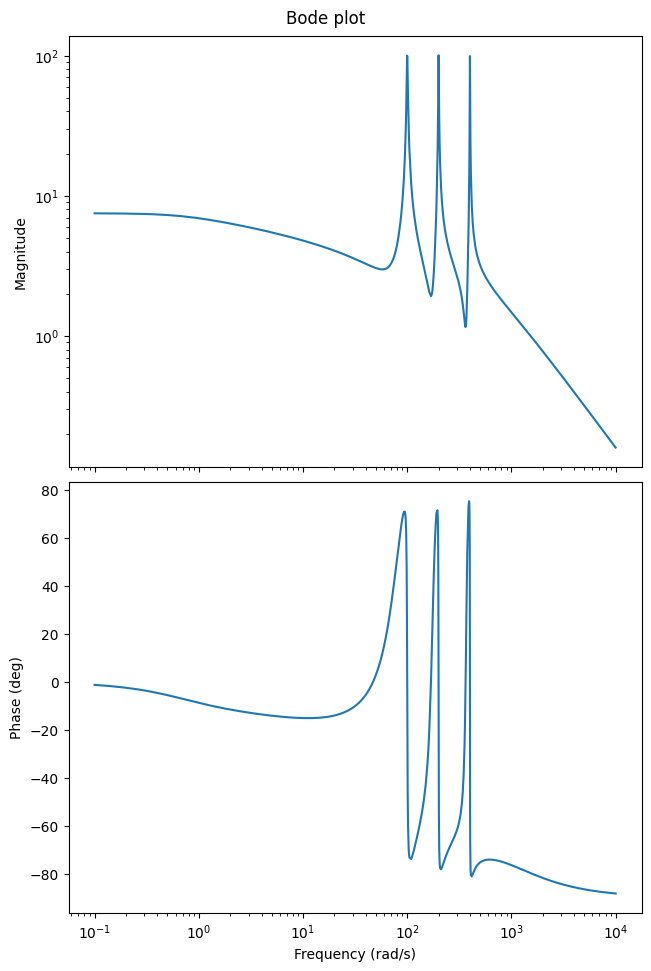

In [13]:
w = (1e-1, 1e4)
_ = fom_lti.transfer_function.bode_plot(w)

Note that if you do not run this code in a [Jupyter](https://jupyter.org) notebook,
you probably need to manually show the plot:

```python3
from matplotlib import pyplot as plt
plt.show()
```

We can run balanced truncation to obtain a reduced-order model.

In [14]:
from pymor.reductors.bt import BTReductor

bt = BTReductor(fom_lti)
rom_lti = bt.reduce(10)

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

The reduced-order model is again an `LTIModel`, but of lower order.

In [15]:
rom_lti

LTIModel(
    NumpyMatrixOperator(<10x10 dense>),
    NumpyMatrixOperator(<10x1 dense>),
    NumpyMatrixOperator(<1x10 dense>),
    D=ZeroOperator(NumpyVectorSpace(1), NumpyVectorSpace(1)),
    E=NumpyMatrixOperator(<10x10 dense>),
    presets={},
    name='LTIModel_reduced')

Looking at the error system, we can see which frequencies are well approximated.

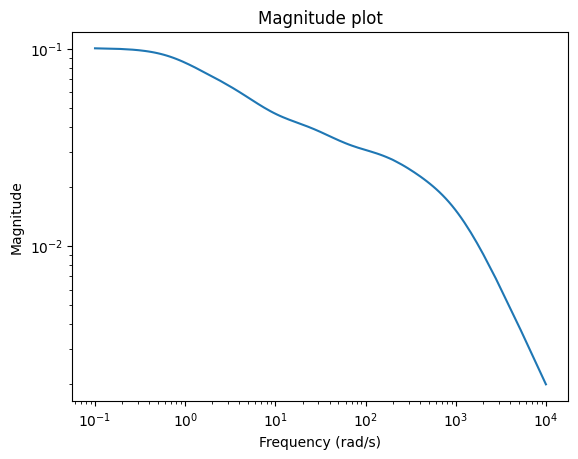

In [16]:
err_lti = fom_lti - rom_lti
_ = err_lti.transfer_function.mag_plot(w)

## Running Demo Scripts

pyMOR ships several example scripts that showcase various features of the library.
While many features are also covered in our {doc}`tutorials`, the demos are more extensive
and often have various command-line flags which allow to run the script for different
parameters or problems.
All demos can be found in the [src/pymordemos](https://github.com/pymor/pymor/tree/main/src/pymordemos)
directory of the source repository.

The demo scripts can be launched directly from the source tree:

```
./thermalblock.py --plot-err --plot-solutions 3 2 3 32
```

or by using the `pymor-demo` script that is installed with pyMOR:

```
pymor-demo thermalblock --plot-err --plot-solutions 3 2 3 32
```

## Learning More

You can find more details on the above approaches,
and even more,
in the {doc}`tutorials`.
Specific questions are answered in
[GitHub discussions](https://github.com/pymor/pymor/discussions).
The {ref}`technical_overview` provides discussion on fundamental pyMOR concepts
and design decisions.

Should you have any problems regarding pyMOR, questions or
[feature requests](https://github.com/pymor/pymor/issues),
do not hesitate to contact us via
[GitHub discussions](https://github.com/pymor/pymor/discussions)
or [email](mailto:main.developers@pymor.org)!

Download the code:
{download}`getting_started.md`
{nb-download}`getting_started.ipynb`